# PHYS 7730 (Data Science) Problem Set Summary
By Kaixin Wang and Prof. Michael Vershinin

## Question 4: Analysis on Binomial distribution
### MLE: [Maximum Likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation)
We model a set of observations as a random sample from an unknown joint probability distribution which is expressed in terms of a set of parameters. 

The goal of maximum likelihood estimation is to determine the parameters for which the observed data have the highest joint probability.

### [Fisher Information](https://en.wikipedia.org/wiki/Fisher_information):
The Fisher information is a way of measuring the amount of information that an observable random variable $X$
carries about an unknown parameter $\theta$ upon which the probability of X depends.

Let $f(X;\theta)$ be the probability density function (or probability mass function) for 
$X$ conditioned on the value of $\theta$. 

It describes the probability that we observe a given outcome of 
$X$, given a known value of $\theta$. 

If $f$ is sharply peaked with respect to changes in $\theta$, 
it is easy to indicate the "correct" value of $\theta$ from the data, or equivalently, that the data 
$X$ provides a lot of information about the parameter $\theta$.

If the likelihood $f$ is flat and spread-out, 
then it would take many samples of $X$ to estimate the actual "true" value of 
$\theta$ that would be obtained using the entire population being sampled.

This suggests studying some kind of variance with respect to $\theta$. 


In [26]:
import numpy as np
import scipy.optimize as SciOpt
import scipy.stats as SciStat
import scipy.special as SciSpec
from numpy import random as rnd
from numpy import linalg as LA
import matplotlib.pyplot as plt

In [27]:
#Problem 1
#Part 1
#I will use N and K for the general case and lowercase for 
#the case of N=n=1, i.e. the single coin flip
#-----------------------------------------------------------------------
#So let's start with Bernoulli trial, i.e. the case of n=1
#In that case k only has two possible values 0 or 1
#-----------------------------------------------------------------------
#Now we are ready to do the usual computation
#L=(p^k)*(1-p)^(1-k) and so logL=k*log(p) + (1-k)*log(1-p)
#logL' = k/p + (1-k)/(1-p)
#-----------------------------------------------------------------------
#To get Fisher information, we need:
#(logL')^2 = (k^2/p^2) + ((1-k)^2/(1-p)^2)+2*k*(1-k)/(p*(1-p))
#And we can average this easily since this is a 2nd order polynomial in k
#so we just need to know how to average k and k^2
#-----------------------------------------------------------------------
#We can use the definition of an average to find <k> 
#<k> = 0*(probability(k=0)) + 1*(probability(k=1)) = 0 + p = p
#Likewise for <k^2>
#<k^2> = (0^2)*(probability(k=0)) + (1^2)*(probability(k=1)) = 0 + p = p
#-----------------------------------------------------------------------
#<(logL')^2> = (p/p^2)+((1-2*p+p)/(1-p)^2) + 2*(p-p)/(p*(1-p))
#I_1 = 1/p + 1/(1-p) = 1/(p*(1-p)) 
#-----------------------------------------------------------------------
#Let's also find the MLE for p (phat) in the general case where N>=1 and K=sum(k):
#logL'=0 : K/phat - (N-K)/(1-phat)=0 ergo phat=K/N as naively expected
#Finally for any N we now have what we need to find error bars on phat
#I_n = N/(phat*(1-phat)) 
#-----------------------------------------------------------------------
#Part 2
phat = lambda N,K: K/N
Zscore=abs(SciStat.norm.ppf((1-0.975)/2, loc=0, scale=1))
err_mag = lambda N, K : Zscore*np.sqrt(phat(N,K)*(1-phat(N,K))/N)
#is known as Wald confidence interval
CI_lo = lambda N, K : phat(N, K) - err_mag(N,K)
CI_hi = lambda N, K : phat(N, K) + err_mag(N,K)

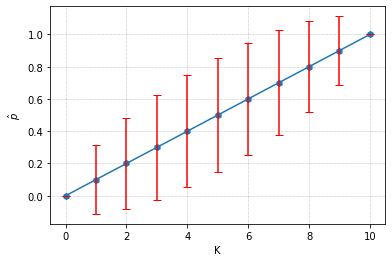

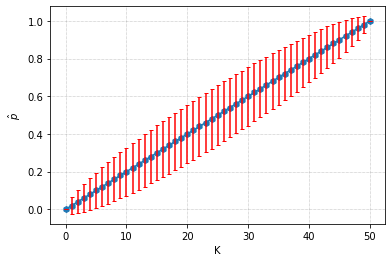

In [28]:
#Part 3
#Let's plot these error bars for various N and K
N=10; K=np.linspace(0,N,N+1)
plt.plot(K, phat(N, K), marker='h')
plt.errorbar(K, phat(N, K), yerr=err_mag(N,K), \
             color='r', ls = "None", markersize=8, capsize=4)
#Add some grid lines and dump to screen
plt.grid(color='gray', linestyle='dotted', linewidth=.5)
plt.xlabel('K')
plt.ylabel(r'$\hat p$')
plt.grid(visible=True)
#Dump plot to screen
plt.show()
#Ouch. Some error bars go below 0 and above 1 which is nonsense
#Clearly K/N cannot be less than 0 (K>=0 and N>=0)
#and K/N cannot be greater than 1 (K<=N)
#-----------------------------------------------------------------------
#Let's see what happens if we have more data
N=50; K=np.linspace(0,N,N+1)
plt.plot(K, phat(N, K),marker='h')
plt.errorbar(K, phat(N, K), yerr=err_mag(N,K), \
             color='r', ls = "None", markersize=8, capsize=2)
#Add some grid lines and dump to screen
plt.grid(color='gray', linestyle='dotted', linewidth=.5)
plt.xlabel('K')
plt.ylabel(r'$\hat p$')
plt.grid(visible=True)
#Dump plot to screen
plt.show()
#Ah. The issue consistently shows up when the K/N fraction
#is either very low or very high
#Notice that if I consider fraction 8/10 in the first case
#the error bars are clearly, without a doubt, wrong!
#but the same fraction (40/50) in the second case looks passable
#
#This seems to be the usual issue with MLE: it only works well
#if you have enough data. For low amounts of data it can fail.
#In some cases, like here, the failure can be outright spectacular

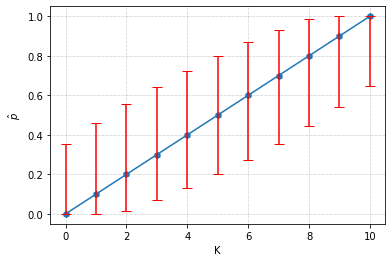

In [29]:
#Part 3 extra
#Let's try to fix MLE interval. Wilson in 1927 proposed a rather complex formula
#with some deep mathematical justification which works great but is a bit hard to
#implement in practice. Agresti and Coull have simplified this confidence interval 
#in a way that works great and is easy to construct.
#Let's just prevent the ratio K/N from getting too close to extremes 
#by adding 2 successes and 2 failures to our data. 
#So in our calculation above we simply use
#K -> K+2 and N - > N+4
#We do need to cut off error bars at zero and 1 if need be
#Let's plot Agresti-Coull error bars for various N and K
N=10; K=np.linspace(0,N,N+1)
plt.plot(K, phat(N, K), marker='h')
AChi=np.clip(phat(N+4, K+2)+err_mag(N+4,K+2),0,1) #Given an interval, values outside the interval 
AClo=np.clip(phat(N+4, K+2)-err_mag(N+4,K+2),0,1) #are clipped to the interval edges (np.clip)
plotline1, caplines1, barlinecols1 = \
plt.errorbar(K, phat(N+4, K+2), color='r', ls = "None", lolims=True, yerr=AChi-phat(N+4, K+2))
plotline2, caplines2, barlinecols2 = \
plt.errorbar(K, phat(N+4, K+2), color='r', ls = "None", uplims=True, yerr=phat(N+4, K+2)-AClo)
caplines1[0].set_marker('_')
caplines1[0].set_markersize(10)
caplines2[0].set_marker('_')
caplines2[0].set_markersize(10)
#Add some grid lines and dump to screen
plt.grid(color='gray', linestyle='dotted', linewidth=.5)
plt.xlabel('K')
plt.ylabel(r'$\hat p$')
plt.grid(visible=True)
#Dump plot to screen
plt.show()
#
#Nice. These error bars are nearly symmetric for proportions near 1/2
#as expected since the binomial distribution is nearly symetric there
#and they become very skewed near the extremes

Start at $p=0.5$ and lower this parameter value gradually numerically.
At every iteration, compute the probability of $k$ or more successes. You can stop right at the point when this net probability becomes lower than 0.025. This value of $p$ is the lower value of the exact confidence limit.

Again, start at $p=0.5$ and raise this parameter value gradually numerically. At every iteration, compute the probability of $k$ or less successes. You can stop right at the point when this net probability becomes lower than 0.025. This value of $p$ is the lower value of the exact confidence limit.

In [30]:
#Part 4
#The procedure outlined in the problem constructs the exact CI
#It is also known as Clopper-Pearson confidence interval
#
#One can implement binomial probability function explicitly
#SciSpec.comb(trials,successes)*np.power(bias,successes)*np.power(1-bias,trials-successes)
#but for readability I use built-in function, which returns the same thing
#SciStat.binom.pmf(successes,trials,bias)
from scipy.stats import binom as Bin

N=10; K=1
CP_plus = lambda bias : \
          np.sum(Bin.pmf(np.arange(0,K+1),N,bias))-.025  # 95% confidential interval

CP_minus = lambda bias : \
          np.sum(Bin.pmf(np.arange(K,N+1),N,bias))-.025  # 95% confidential interval

#Now we just find the root between 0 and 1
#To keep with problem wording we use the bisection method
#which gives us the first bisection point at 0.5
lolim=SciOpt.bisect(CP_minus,0,1) # Find root of a function (=0) within an interval using bisection
hilim=SciOpt.bisect(CP_plus,0,1)
print('The exact 95% CI from our custom code is :')
print('(' + str(lolim) + ', ' + str(hilim) + ' )')

#We can also check our solution via comparison
#with the built-in Clopper-Pearson CI
#It turns out that the sum of binomial probabilities
#can be expressed in terms of Beta function 
#so statsmodels uses method='beta' to refer to the exact CI
import statsmodels.stats.proportion as smP
print('The exact 95% CI from built-in python code :')
print(smP.proportion_confint(K,N,.05, method='beta'))

The exact 95% CI from our custom code is :
(0.0025285785432060948, 0.4450161170298088 )
The exact 95% CI from built-in python code :
(0.0025285785444617848, 0.4450161170281953)


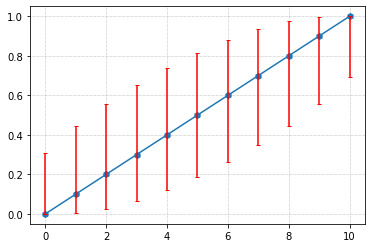

In [34]:
#Let's plot these error bars for various K 
#and the same N as before
N=10; 
#We will find the low and high limits for our CI
limLO =np.zeros(N+1)
limHI =np.zeros(N+1)
#But it is easier in python's matplotlib
#to plot symmetric CI so we need midpoint too
limMID=np.zeros(N+1)
#And while we are at it, might as well compute 
#the size of error bars around the CI midpoint
limSZ =np.zeros(N+1)
#Now we just run through the same K as before
for K in np.linspace(0,N,N+1):
    #N is already defined so we can directly write
    #down the sums that the problem described
    CP_plus = lambda bias : \
          np.sum(Bin.pmf(np.arange(0,K+1),N,bias))-.025
    #
    CP_minus = lambda bias : \
          np.sum(Bin.pmf(np.arange(K,N+1),N,bias))-.025
    #We now find the CI limits, except that bisect method
    #will not work well at the very ends so we make these
    #into rather trivial special cases
    if K>0:
        limLO[int(K)]=SciOpt.bisect(CP_minus,0,1);
    else:
        limLO[int(K)]=0 #yes, I know it is already zero
        #This line is both for symmetry and just to be sure
        #in case someone later changes the code above this line
    #
    if K<N:
        limHI[int(K)]=SciOpt.bisect(CP_plus,0,1);
    else:
        limHI[int(K)]=1
    #OK, now we just populate convinience variables
    #to make plotting easier
    limMID[int(K)] = (limLO[int(K)] + limHI[int(K)])/2
    limSZ[int(K)]  = limHI[int(K)]-limMID[int(K)]
#Finally, plot the results, with same style as above
K=np.linspace(0,N,N+1)
plt.plot(K, phat(N, K), marker='h')
plt.errorbar(K, limMID, yerr=limSZ, \
             color='r', ls = "None", markersize=0, capsize=2)
#Add some grid lines and dump to screen
plt.grid(color='gray', linestyle='dotted', linewidth=.5)
plt.grid(visible=True)
#Dump plot to screen
plt.show()
#This CI looks pretty similar to AC one
#But AC intervals tend to be a bit smaller
#Exact interval is rather conservative

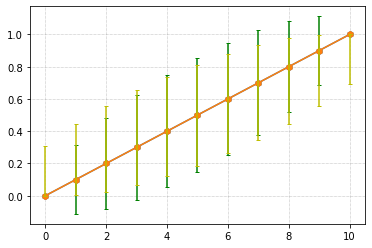

In [33]:
K=np.linspace(0,N,N+1)
#MLE error bars are green
plt.plot(K, phat(N, K), marker='h')
plt.errorbar(K, phat(N, K), yerr=err_mag(N,K), \
             color='g', ls = "None", markersize=8, capsize=2)
#exact error bars are yellow
plt.plot(K, phat(N, K), marker='h')
plt.errorbar(K, limMID, yerr=limSZ, \
             color='y', ls = "None", markersize=0, capsize=2)
#Add some grid lines and dump to screen
plt.grid(color='gray', linestyle='dotted', linewidth=.5)
plt.grid(visible=True)
#Dump plot to screen
plt.show()
#Sure looks like MLE only gives decent error bars 
#if you have tons and tons of data or near p=0.5